##### **Data source**

The data used in this post 2 for data preprocessing was extracted from ChEMBL database by using ChEMBL web resource client in Python. The details of all the steps taken to reach the final .csv file could be seen in [post 1](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/1_data_col_prep.html). 

<br>

##### **Checklist for preprocessing ChEMBL compound data**

Below was a checklist summary for post 1 and post 2 (current post), and was highly inspired by this journal paper [@vantilborg2022] and also ChEMBL's FAQ on "[Assay and Activity Questions](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions)".

*Note: not an exhaustive list, only a suggestion from my experience working on this series, may need to tailor to different scenarios*

For molecular data containing chemical compounds, check for:

- duplicates
- missing values
- salts or mixture

Check the consistency of structural annotations:

- molecular validity
- molecular sanity
- charge standardisation
- stereochemistry

Check the reliability of reported experimental values (e.g. activity values like IC50, Ki, EC50 etc.):

- annotated validity (data_validity_comment)
- presence of outliers
- confidence score (assays)
- standard deviation of multiple entries (if applicable)

<br>

##### **Import libraries**

In [1]:
# Import all libraries used
import pandas as pd
import math
from rdkit.Chem import Descriptors
import datamol as dm
# tqdm library used in datamol's batch descriptor code
from tqdm import tqdm
import mols2grid

<br>

##### **Re-import saved data**

Re-imported the partly preprocessed data from the earlier post.

In [2]:
dtree_df = pd.read_csv("ache_chembl.csv")
dtree_df.head(3)

,Unnamed: 0,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles
0,0,CHEMBL11805,0.104,nM,Potential transcription error,NaN,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...
1,1,CHEMBL60745,1.630,nM,NaN,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-]
2,2,CHEMBL208599,0.026,nM,NaN,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2


There was an extra index column (named "Unnamed: 0") here, which was likely inherited from how the .csv file was saved with the index already in place from part 1, so this column was dropped for now.

In [3]:
dtree_df = dtree_df.drop("Unnamed: 0", axis = 1)
dtree_df.head(3)

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles
0,CHEMBL11805,0.104,nM,Potential transcription error,NaN,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...
1,CHEMBL60745,1.630,nM,NaN,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-]
2,CHEMBL208599,0.026,nM,NaN,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2


<br>

##### **Calculate pKi**

The distribution of Ki values were shown below via a simple statistical summary.

In [4]:
dtree_df["Ki"].describe()

count    5.400000e+02
mean     2.544039e+05
std      4.103437e+06
min      1.700000e-03
25%      2.437500e+01
50%      1.995000e+02
75%      3.100000e+03
max      9.496300e+07
Name: Ki, dtype: float64

From the above quick statistical summary and also the code below to find the minimum Ki value, it confirmed there were no zero Ki values recorded.

In [5]:
dtree_df["Ki"].min()

0.0017

Now the part about converting the Ki values to pKi values, which were the negative logs of Ki in molar units (a [PubChem example](https://pubchem.ncbi.nlm.nih.gov/bioassay/213088) might help to explain it a little). The key to understand pKi here was to treat pKi similarly to how we normally understand pH for our acids and bases. The formula to convert Ki to pKi for nanomolar (nM) units was: 

$$
\text{pKi} = 9 - log _{10}(Ki)
$$

Set up a small function to do the conversion.

In [6]:
def calc_pKi(Ki):
    pKi_value = 9 - math.log10(Ki)
    return pKi_value

Applying the calc_pKi function to convert all rows of the compound dataset for the "Ki" column.

In [7]:
# Create a new column for pKi
# Apply calc_pKi function to data in Ki column
dtree_df["pKi"] = dtree_df.apply(lambda x: calc_pKi(x.Ki), axis = 1)

The dataframe would now look like this, with a new pKi column (scroll to the very right to see it).

In [8]:
dtree_df.head(3)

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi
0,CHEMBL11805,0.104,nM,Potential transcription error,NaN,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
1,CHEMBL60745,1.630,nM,NaN,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812
2,CHEMBL208599,0.026,nM,NaN,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027


<br>

##### **Plan other data preprocessing steps**

For a decision tree model, a few more molecular descriptors were most likely needed rather than only Ki or pKi and SMILES, since I've now arrived at the step of planning other preprocessing steps. One way to do this could be through computations based on canonical SMILES of compounds by using RDKit, which would give the RDKit 2D descriptors. In this single tree model, I decided to stick with only RDKit 2D descriptors for now, before adding on fingerprints (as a side note: I have very lightly touched on generating fingerprints in this earlier post - ["Molecular similarities in selected COVID-19 antivirals"](https://jhylin.github.io/Data_in_life_blog/posts/07_Molecular_similarities_in_COVID-19_antivirals/Mol_sim_covid.html) in the subsection on "Fingerprint generator").

At this stage, a compound sanitisation step should also be applied to the compound column before starting any calculations to rule out compounds with questionable chemical validities. RDKit or Datamol (a Python wrapper library built based on RDKit) was also capable of doing this. 

I've added a quick step here to convert the data types of "smiles" and "data_validity_comment" columns to string (in case of running into problems later).

In [9]:
dtree_df = dtree_df.astype({"smiles": "string", "data_validity_comment": "string"})
dtree_df.dtypes

molecule_chembl_id               object
Ki                              float64
units                            object
data_validity_comment    string[python]
max_phase                       float64
smiles                   string[python]
pKi                             float64
dtype: object

<br>

##### **Check data validity**

Also, before jumping straight to compound sanitisation, I needed to check the "data_validity_comment" column.

In [10]:
dtree_df["data_validity_comment"].unique()

<StringArray>
['Potential transcription error', <NA>, 'Outside typical range']
Length: 3, dtype: string

There were 3 different types of data validity comments here, which were "Potential transcription error", "NaN"  and "Outside typical range". So, this meant compounds with comments as "Potential transcription error" and "Outside typical range" should be addressed first.

In [11]:
# Find out number of compounds with "outside typical range" as data validity comment
dtree_df_err = dtree_df[dtree_df["data_validity_comment"] == "Outside typical range"]
print(dtree_df_err.shape)
dtree_df_err.head()

(58, 7)


,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi
111,CHEMBL225198,0.0090,nM,Outside typical range,NaN,O=C(CCc1c[nH]c2ccccc12)NCCCCCCCNc1c2c(nc3cc(Cl...,11.045757
114,CHEMBL225021,0.0017,nM,Outside typical range,NaN,O=C(CCCc1c[nH]c2ccccc12)NCCCCCNc1c2c(nc3cc(Cl)...,11.769551
118,CHEMBL402976,313700.0000,nM,Outside typical range,NaN,CN(C)CCOC(=O)Nc1ccncc1,3.503485
119,CHEMBL537454,140200.0000,nM,Outside typical range,NaN,CN(C)CCOC(=O)Nc1cc(Cl)nc(Cl)c1.Cl,3.853252
120,CHEMBL3216883,316400.0000,nM,Outside typical range,NaN,CN(C)CCOC(=O)Nc1ccncc1Br.Cl.Cl,3.499764


There were a total of 58 compounds with Ki outside typical range. 

In [12]:
dtree_df_err2 = dtree_df[dtree_df["data_validity_comment"] == "Potential transcription error"]
dtree_df_err2

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi
0,CHEMBL11805,0.104,nM,Potential transcription error,NaN,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967


With the other comment for potential transciption error, there seemed to be only one compound here.

These compounds with questionable Ki values were removed, as they could be potential sources of errors in ML models later on (error trickling effect). One of the ways to filter out data was to fill the empty cells within the "data_validity_comment" column first, so those ones to be kept could be selected.

In [13]:
# Fill "NaN" entries with an actual name e.g. none
dtree_df["data_validity_comment"].fillna("none", inplace=True)
dtree_df.head()

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi
0,CHEMBL11805,0.104,nM,Potential transcription error,NaN,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
1,CHEMBL60745,1.630,nM,none,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812
2,CHEMBL208599,0.026,nM,none,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027
3,CHEMBL95,151.000,nM,none,4.0,Nc1c2c(nc3ccccc13)CCCC2,6.821023
4,CHEMBL173309,12.200,nM,none,NaN,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,7.913640


Filtered out only the compounds with nil data validity comments.

In [14]:
#dtree_df["data_validity_comment"].unique()
dtree_df = dtree_df[dtree_df["data_validity_comment"] == "none"]

Checking the dtree_df dataframe again and also whether if only the compounds with "none" labelled for "data_validity_comment" column were kept.

In [15]:
print(dtree_df.shape)
dtree_df["data_validity_comment"].unique()

(481, 7)


<StringArray>
['none']
Length: 1, dtype: string

<br>

##### **Sanitise compounds**

This [preprocessing molecules tutorial](https://docs.datamol.io/stable/tutorials/Preprocessing.html) and reference links provided by Datamol were very informative, and the preprocess function code by Datamol was used below. Each step of fix_mol(), sanitize_mol() and standardize_mol() was explained in this tutorial. I think the key was to select preprocessing options required to fit the purpose of the ML models, and the more experiences in doing this, the more likely it will help with the preprocessing step.

In [16]:
# _preprocess function to sanitise compounds - adapted from datamol.io

smiles_column = "smiles"

dm.disable_rdkit_log()

def _preprocess(row):
    # Convert each compound to a RDKit molecule in the smiles column
    mol = dm.to_mol(row[smiles_column], ordered=True)
    # Fix common errors in the molecules
    mol = dm.fix_mol(mol)
    # Sanitise the molecules 
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    # Standardise the molecules
    mol = dm.standardize_mol(
        mol,
        # Switch on to disconnect metal ions
        disconnect_metals=True,
        normalize=True,
        reionize=True,
        # Switch on "uncharge" to neutralise charges
        uncharge=True,
        # Taking care of stereochemistries of compounds
        stereo=True,
    )

    # Added a new column below for RDKit molecules
    row["rdkit_mol"] = dm.to_mol(mol)
    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

Then the compound sanitisation function was applied to the dtree_df.

In [17]:
dtree_san_df = dtree_df.apply(_preprocess, axis = 1)
dtree_san_df.head()

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi,rdkit_mol,standard_smiles,selfies,inchi,inchikey
1,CHEMBL60745,1.630,nM,none,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812,<rdkit.Chem.rdchem.Mol object at 0x11ed256d0>,CC[N+](C)(C)c1cccc(O)c1.[Br-],[C][C][N+1][Branch1][C][C][Branch1][C][C][C][=...,"InChI=1S/C10H15NO.BrH/c1-4-11(2,3)9-6-5-7-10(1...",CAEPIUXAUPYIIJ-UHFFFAOYSA-N
2,CHEMBL208599,0.026,nM,none,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027,<rdkit.Chem.rdchem.Mol object at 0x11ed25740>,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,[C][C][C][=C][C][C][C][=N][C][=C][C][Branch1][...,InChI=1S/C18H19ClN2/c1-2-10-5-11-7-12(6-10)17-...,QTPHSDHUHXUYFE-KIYNQFGBSA-N
3,CHEMBL95,151.000,nM,none,4.0,Nc1c2c(nc3ccccc13)CCCC2,6.821023,<rdkit.Chem.rdchem.Mol object at 0x11ed257b0>,Nc1c2c(nc3ccccc13)CCCC2,[N][C][=C][C][=Branch1][N][=N][C][=C][C][=C][C...,InChI=1S/C13H14N2/c14-13-9-5-1-3-7-11(9)15-12-...,YLJREFDVOIBQDA-UHFFFAOYSA-N
4,CHEMBL173309,12.200,nM,none,NaN,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,7.913640,<rdkit.Chem.rdchem.Mol object at 0x11ed25820>,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,[C][C][N][Branch2][Branch1][Ring1][C][C][C][C]...,InChI=1S/C42H70N4O4/c1-7-45(35-37-25-17-19-27-...,VJXLWYGKZGTXAF-UHFFFAOYSA-N
5,CHEMBL1128,200.000,nM,none,4.0,CC[N+](C)(C)c1cccc(O)c1.[Cl-],6.698970,<rdkit.Chem.rdchem.Mol object at 0x11ed25890>,CC[N+](C)(C)c1cccc(O)c1.[Cl-],[C][C][N+1][Branch1][C][C][Branch1][C][C][C][=...,"InChI=1S/C10H15NO.ClH/c1-4-11(2,3)9-6-5-7-10(1...",BXKDSDJJOVIHMX-UHFFFAOYSA-N


If the dataset required for sanitisation is large, Datamol has suggested using their example code to add parallelisation as shown below.

``` {{python}}
# Code adapted from: https://docs.datamol.io/stable/tutorials/Preprocessing.html#references
data_clean = dm.parallelized(
    _preprocess, 
    data.iterrows(), 
    arg_type="args", 
    progress=True, 
    total=len(data)
    )
data_clean = pd.DataFrame(data_clean)
```

In [18]:
dtree_san_df.shape

(481, 12)

In this case, I tried using the preprocessing function without adding parallelisation, the whole process wasn't very long (since I had a small dataset), and was done within a minute or so.

Also, as a sanity check on the sanitised compounds in dtree_san_df, I just wanted to see if I could display all compounds in this dataframe as 2D images. I also had a look through each page just to see if there were any odd bonds or anything strange in general.

In [19]:
# Create a list to store all cpds in dtree_san_df
mol_list = dtree_san_df["rdkit_mol"]
# Convert to list
mol_list = list(mol_list)
# Check data type
type(mol_list)
# Show 2D compound structures in grids
mols2grid.display(mol_list)

# Note: Jupyter notebook stored in GitHub repo will not show the interactive grid 
# - please visit post 2 URL link to see the rendered & interactive version

MolGridWidget()

<br>

##### **Detect outliers**

Plotting a histogram to see the distribution of pKi values first.

array([[<Axes: title={'center': 'pKi'}>]], dtype=object)

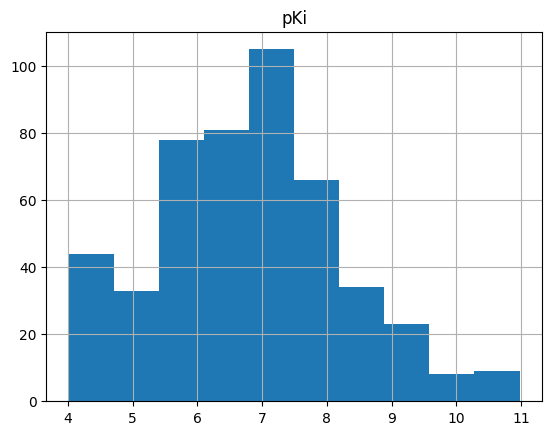

In [20]:
dtree_san_df.hist(column = "pKi")

I read a bit about Dixon's Q test and realised that there were a few required assumptions prior to using this test, and the current dataset used here (dtree_san_df) might not fit the requirements, which were:

-   normally distributed data
-   a small sample size e.g. between 3 and 10, which was originally stated in this paper [@dean1951].

I've also decided that rather than showing Python code for Dixon's Q test myself, I would attach a few examples from others instead, for example, [Q test from Plotly](https://plotly.com/python/v3/outlier-test/) and [Dixon's Q test for outlier identification -- a questionable practice](https://sebastianraschka.com/Articles/2014_dixon_test.html), since this dataset here wasn't quite normally distributed as shown from the histogram above.

<Axes: >

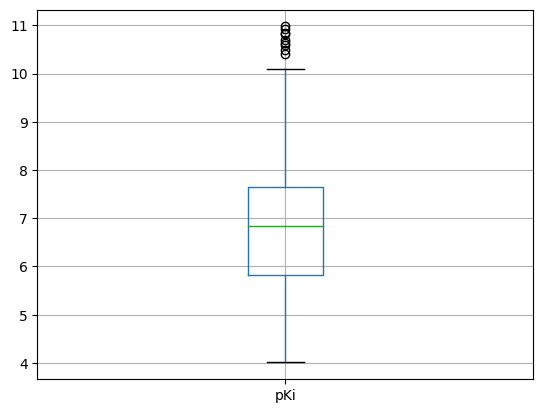

In [21]:
dtree_san_df.boxplot(column = "pKi")

# the boxplot version below shows a blank background
# rather than above version with horizontal grid lines
#dtree_san_df.plot.box(column = "pKi")

I also used Pandas' built-in boxplot in addition to the histogram to show the possible outliers within the pKi values. Clearly, the outliers for pKi values appeared to be above 10. I also didn't remove these outliers completely due to the dataset itself wasn't quite in a Gaussian distribution (they might not be true outliers).

<br>

##### **Calculate RDKit 2D molecular descriptors**

I've explored a few different ways to compute molecular descriptors, essentially RDKit was used as the main library to do this (there might be other options via other programming languages, but I was only exploring RDKit-based methods via Python for now). A [blog post](https://drzinph.com/rdkit_2d-descriptors-in-python-part-4/) I've come across on calculating RDKit 2D molecular descriptors has explained it well, it gave details about how to bundle the functions together in a class (the idea of building a small library yourself to be used in projects was quite handy). I've also read RDKit's documentations and also the ones from Datamol. So rather than re-inventing the wheels of all the RDKit code, I've opted to use only a small chunk of RDKit code as a demonstration, then followed by Datamol's version to compute the 2D descriptors, since there were already a few really well-explained blog posts about this. One of the examples was this useful [descriptor calculation tutorial](https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html) by Greg Landrum.



<br>

###### **RDKit code**

With the lastest format of the dtree_san_df, it already included a RDKit molecule column (named "rdkit_mol"), so this meant I could go ahead with the calculations. So here I used RDKit's Descriptors.CalcMolDescriptors() to calculate the 2D descriptors - note: there might be more code variations depending on needs, this was just a small example.

In [22]:
# Run descriptor calculations on mol_list (created earlier)
# and save as a new list
mol_rdkit_ls = [Descriptors.CalcMolDescriptors(mol) for mol in mol_list]

# Convert the list into a dataframe
df_rdkit_2d = pd.DataFrame(mol_rdkit_ls)
print(df_rdkit_2d.shape)
df_rdkit_2d.head(3)

(481, 209)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.261910,9.261910,0.000000,0.000000,0.662462,246.148,230.020,245.041526,74,0,...,0,0,0,0,0,0,0,0,0,0
1,6.509708,6.509708,0.547480,0.547480,0.763869,298.817,279.665,298.123676,108,0,...,0,0,0,0,0,0,0,0,0,0
2,6.199769,6.199769,0.953981,0.953981,0.706488,198.269,184.157,198.115698,76,0,...,0,0,0,0,0,0,0,0,0,0


In total, it generated 209 descriptors. 

<br>

###### **Datamol code**

Then I tested Datamol's code on this as shown below.

In [23]:
# Datamol's batch descriptor code for a list of compounds
dtree_san_df_dm = dm.descriptors.batch_compute_many_descriptors(mol_list)
print(dtree_san_df_dm.shape)
dtree_san_df_dm.head(3)

(481, 22)


,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,245.041526,0.400000,2,1,1,3,13,2,0,20.23,...,3.185866,0,0,0,1,0,1,0,0,0
1,298.123676,0.388889,2,2,4,3,21,1,0,38.91,...,4.331775,2,0,2,1,1,2,0,0,0
2,198.115698,0.307692,2,2,3,2,15,0,0,38.91,...,2.014719,1,0,1,1,1,2,0,0,0


There were a total of 22 molecular descriptors generated, which seemed more like what I might use for the decision tree model. The limitation with this batch descriptor code was that the molecular features were pre-selected, so if other types were needed, it would be the best to go for RDKit code or look into other Datamol descriptor code that allow users to specify features. The types of descriptors were shown below.

In [24]:
dtree_san_df_dm.columns

Index(['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings',
       'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds',
       'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas',
       'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles',
       'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles',
       'n_aromatic_rings', 'n_saturated_carbocycles',
       'n_saturated_heterocyles', 'n_saturated_rings'],
      dtype='object')

<br>

##### **Combine dataframes**

The trickier part for data preprocessing was actually trying to merge, join or concatenate dataframes of the preprocessed dataframe (dtree_san_df) and the dataframe from Datamol's descriptor code (dtree_san_df_dm). 

Initially, I tried using all of Pandas' code of merge/join/concat() dataframes. They all failed to create the correct final combined dataframe with too many rows generated, with one run actually created more than 500 rows (maximum should be 481 rows). One of the possible reasons for this could be that some of the descriptors had zeros generated as results for some of the compounds, and when combining dataframes using Pandas code like the ones mentioned here, they might cause unexpected results (as suggested by Pandas, these code were not exactly equivalent to SQL joins). So I looked into different ways, and while there were no other common columns for both dataframes, the index column seemed to be the only one that correlated both.

I also found out after going back to the previous steps that when I applied the compound preprocessing function from Datamol, the index of the resultant dataframe was changed to start from 1 (rather than zero). Because of this, I tried re-setting the index of dtree_san_df first, then dropped the index column, followed by re-setting the index again to ensure it started at zero, which has worked. So now the dtree_san_df would have exactly the same index as the one for dtree_san_df_dm.

In [25]:
# 1st index re-set
dtree_san_df = dtree_san_df.reset_index()
# Drop the index column
dtree_san_df = dtree_san_df.drop(["index"], axis = 1)
dtree_san_df.head(3)

,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi,rdkit_mol,standard_smiles,selfies,inchi,inchikey
0,CHEMBL60745,1.630,nM,none,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812,<rdkit.Chem.rdchem.Mol object at 0x11ed256d0>,CC[N+](C)(C)c1cccc(O)c1.[Br-],[C][C][N+1][Branch1][C][C][Branch1][C][C][C][=...,"InChI=1S/C10H15NO.BrH/c1-4-11(2,3)9-6-5-7-10(1...",CAEPIUXAUPYIIJ-UHFFFAOYSA-N
1,CHEMBL208599,0.026,nM,none,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027,<rdkit.Chem.rdchem.Mol object at 0x11ed25740>,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,[C][C][C][=C][C][C][C][=N][C][=C][C][Branch1][...,InChI=1S/C18H19ClN2/c1-2-10-5-11-7-12(6-10)17-...,QTPHSDHUHXUYFE-KIYNQFGBSA-N
2,CHEMBL95,151.000,nM,none,4.0,Nc1c2c(nc3ccccc13)CCCC2,6.821023,<rdkit.Chem.rdchem.Mol object at 0x11ed257b0>,Nc1c2c(nc3ccccc13)CCCC2,[N][C][=C][C][=Branch1][N][=N][C][=C][C][=C][C...,InChI=1S/C13H14N2/c14-13-9-5-1-3-7-11(9)15-12-...,YLJREFDVOIBQDA-UHFFFAOYSA-N


In [26]:
# 2nd index re-set
dtree_san_df = dtree_san_df.reset_index()
print(dtree_san_df.shape)
dtree_san_df.head(3)

(481, 13)


,index,molecule_chembl_id,Ki,units,data_validity_comment,max_phase,smiles,pKi,rdkit_mol,standard_smiles,selfies,inchi,inchikey
0,0,CHEMBL60745,1.630,nM,none,NaN,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812,<rdkit.Chem.rdchem.Mol object at 0x11ed256d0>,CC[N+](C)(C)c1cccc(O)c1.[Br-],[C][C][N+1][Branch1][C][C][Branch1][C][C][C][=...,"InChI=1S/C10H15NO.BrH/c1-4-11(2,3)9-6-5-7-10(1...",CAEPIUXAUPYIIJ-UHFFFAOYSA-N
1,1,CHEMBL208599,0.026,nM,none,NaN,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027,<rdkit.Chem.rdchem.Mol object at 0x11ed25740>,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,[C][C][C][=C][C][C][C][=N][C][=C][C][Branch1][...,InChI=1S/C18H19ClN2/c1-2-10-5-11-7-12(6-10)17-...,QTPHSDHUHXUYFE-KIYNQFGBSA-N
2,2,CHEMBL95,151.000,nM,none,4.0,Nc1c2c(nc3ccccc13)CCCC2,6.821023,<rdkit.Chem.rdchem.Mol object at 0x11ed257b0>,Nc1c2c(nc3ccccc13)CCCC2,[N][C][=C][C][=Branch1][N][=N][C][=C][C][=C][C...,InChI=1S/C13H14N2/c14-13-9-5-1-3-7-11(9)15-12-...,YLJREFDVOIBQDA-UHFFFAOYSA-N


Also re-setting the index of the dtree_san_df_dm.

In [27]:
dtree_san_df_dm = dtree_san_df_dm.reset_index()
print(dtree_san_df_dm.shape)
dtree_san_df_dm.head(3)

(481, 23)


,index,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,0,245.041526,0.400000,2,1,1,3,13,2,0,...,3.185866,0,0,0,1,0,1,0,0,0
1,1,298.123676,0.388889,2,2,4,3,21,1,0,...,4.331775,2,0,2,1,1,2,0,0,0
2,2,198.115698,0.307692,2,2,3,2,15,0,0,...,2.014719,1,0,1,1,1,2,0,0,0


Merged both dataframes of dtree_san_df and dtree_san_df_dm based on their indices.

In [28]:
# merge dtree_san_df & dtree_san_df_dm
dtree_f_df = pd.merge(
    dtree_san_df[["index", "molecule_chembl_id", "pKi", "max_phase"]],
    dtree_san_df_dm,
    left_index=True,
    right_index=True
)

Checking final dataframe to make sure there were 481 rows (also that index_x and index_y were identical) and also there was an increased number of columns (columns combined from both dataframes). So this finally seemed to work.

In [29]:
print(dtree_f_df.shape)
dtree_f_df.head(3)

(481, 27)


,index_x,molecule_chembl_id,pKi,max_phase,index_y,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,0,CHEMBL60745,8.787812,NaN,0,245.041526,0.400000,2,1,1,...,3.185866,0,0,0,1,0,1,0,0,0
1,1,CHEMBL208599,10.585027,NaN,1,298.123676,0.388889,2,2,4,...,4.331775,2,0,2,1,1,2,0,0,0
2,2,CHEMBL95,6.821023,4.0,2,198.115698,0.307692,2,2,3,...,2.014719,1,0,1,1,1,2,0,0,0


The two index columns ("index_x" and "index_y") were removed, which brought out the final preprocessed dataframe.

In [30]:
# Remove index_x & index_y
dtree_f_df.drop(["index_x", "index_y"], axis = 1, inplace = True)
dtree_f_df.head(3)

,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,NaN,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,NaN,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0


I then saved this preprocessed dataframe as another file in my working directory, so that it could be used for estimating experimental errors and model building in the next post.

In [31]:
dtree_f_df.to_csv("ache_2d_chembl.csv")

<br>

##### **Data preprocessing reflections**

In general, the order of steps could be swapped in a more logical way. The subsections presented in this post bascially reflected my thought processes, as there were some back-and-forths. The whole data preprocessing step was probably still not thorough enough, but I've tried to cover as much as I could (hopefully I didn't go overboard with it...). Also, it might still not be ideal to use Ki values this freely as mentioned in post 1 (noises in data issues).

It was mentioned in *scikit-learn* that for decision tree models, because of its non-parametric nature, there were not a lot of data cleaning required. However, I think that might be domain-specific, since for the purpose of drug discovery, if this step wasn't done properly, whatever result that came out of the ML model most likely would not work and also would not reflect real-life scenarios. I was also planning on extending this series to add more trees to the model, that is, from one tree (decision tree), to multiple trees (random forests), and then hopefully move on to boosted trees (XGBoost and LightGBM). Therefore, I'd better do this data cleaning step well first to save some time later (if using the same set of data).

Next post will be about model building using *scikit-learn* and also a small part on estimating experimental errors on the dataset - this is going to be in [post 3](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/3_model_build.html).